# Time Series Transformer Model

In [1]:
pip install torch numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

# Load Reliance.csv
data = pd.read_csv('RELIANCE.csv', parse_dates=['Date'], index_col='Date')
# Use closing prices and compute returns for volatility
prices = data['Close']
returns = prices.pct_change().dropna()

## Data Preparation

In [2]:
import numpy as np
import pandas as pd
import torch

# Synthetic time series
time = np.arange(0, 400, 0.1)
series = np.sin(0.02 * time) + 0.5 * np.random.randn(len(time))

# Create input-output sequences
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

seq_len = 20
X, y = create_sequences(series, seq_len)
X = torch.from_numpy(X).float().unsqueeze(-1)  # (batch, seq, 1)
y = torch.from_numpy(y).float().unsqueeze(-1)  # (batch, 1)


## Model Definition

In [3]:
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, d_model=64,
                 nhead=4, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.src_embedding = nn.Linear(feature_size, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, seq_len, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        # src shape: (batch, seq_len, feature_size)
        x = self.src_embedding(src) + self.pos_encoder
        # Transformer expects (seq_len, batch, d_model)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x[-1, :, :]               # take last time step
        out = self.decoder(x)         # (batch, 1)
        return out

model = TimeSeriesTransformer()  


C:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Training Loop

In [4]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

dataset = TensorDataset(X, y)
loader  = DataLoader(dataset, batch_size=32, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss {total_loss/len(loader):.4f}")


Epoch 1, Loss 0.3036
Epoch 2, Loss 0.2791
Epoch 3, Loss 0.2734
Epoch 4, Loss 0.2734
Epoch 5, Loss 0.2707
Epoch 6, Loss 0.2698
Epoch 7, Loss 0.2696
Epoch 8, Loss 0.2720
Epoch 9, Loss 0.2663
Epoch 10, Loss 0.2685
Epoch 11, Loss 0.2693
Epoch 12, Loss 0.2654
Epoch 13, Loss 0.2654
Epoch 14, Loss 0.2663
Epoch 15, Loss 0.2653
Epoch 16, Loss 0.2669
Epoch 17, Loss 0.2670
Epoch 18, Loss 0.2649
Epoch 19, Loss 0.2646
Epoch 20, Loss 0.2624


## Evaluation

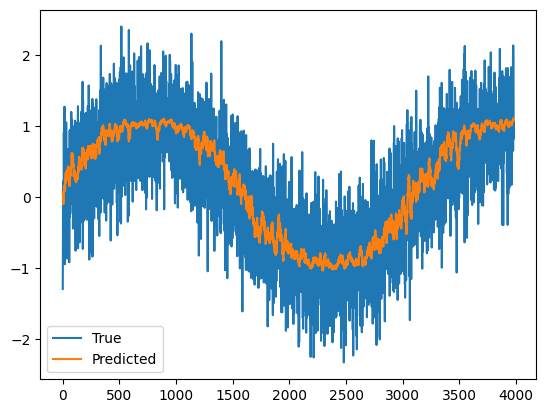

In [5]:
model.eval()
with torch.no_grad():
    preds = model(X).squeeze().numpy()
import matplotlib.pyplot as plt

plt.plot(series[seq_len:], label='True')
plt.plot(preds,    label='Predicted')
plt.legend(); plt.show()

## Metrics

In [6]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure your model and data are on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X = X.to(device)
y = y.to(device)

# Switch model to evaluation mode and disable gradient computation
model.eval()
with torch.no_grad():
    # Generate predictions
    preds = model(X).squeeze().cpu().numpy()  # (batch,) array of predictions
    y_true = y.squeeze().cpu().numpy()        # (batch,) array of true values

# Compute accuracy metrics
mse = mean_squared_error(y_true, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)  # This is the accuracy score for regression

from sklearn.metrics import f1_score

# Direction encoding: 1 if increase, 0 otherwise
true_direction = (y_true[1:] > y_true[:-1]).astype(int)
pred_direction = (preds[1:] > y_true[:-1]).astype(int)

# Compute F1 Score on direction prediction
f1 = f1_score(true_direction, pred_direction, zero_division=1)

# Print results
print(f"Transformer Model Accuracy Metrics:")
print(f"  R² Score (Accuracy)      : {r2:.4f}")
print(f"  Mean Squared Error (MSE) : {mse:.4f}")
print(f"  Root MSE (RMSE)          : {rmse:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")
print(f"  F1 Score (Direction)     : {f1:.4f}")

Transformer Model Accuracy Metrics:
  R² Score (Accuracy)      : 0.6352
  Mean Squared Error (MSE) : 0.2667
  Root MSE (RMSE)          : 0.5164
  Mean Absolute Error (MAE): 0.4112
  F1 Score (Direction)     : 0.7441


## Actual vs predicted closing graph

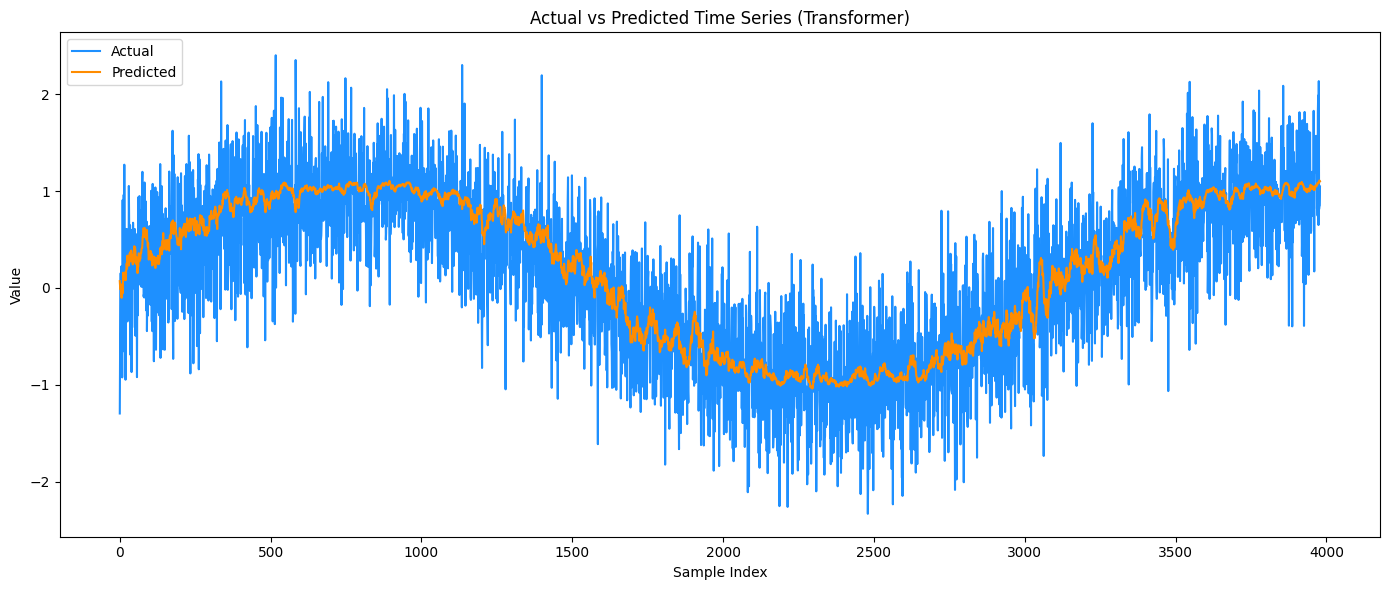

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_true, label='Actual', color='dodgerblue')
plt.plot(preds, label='Predicted', color='darkorange')
plt.title("Actual vs Predicted Time Series (Transformer)")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()
